# 1. Get Data to learn patterns from

- More complex the patterns present in the data, more complex model is required
- Simpler the patterns present in the data, simpler model is required

In [1]:
import torch
import torchvision
import datasets as huggingface_datasets
import lightning
import torchmetrics

def get_dataloaders():
    class Custom_Dataset(torch.utils.data.Dataset):
        def __init__(self, dataset):
            self.dataset = dataset
            self.data_transformations = torchvision.transforms.Compose(
                [
                    torchvision.transforms.ToTensor(),
                ]
            )
            
        def __getitem__(self, index):
            image , label  = self.dataset[index]['image'], self.dataset[index]['label']
            image_tensor   = self.data_transformations(image)
            single_example = (image_tensor, label)
            return single_example
        
        def __len__(self):
            return len(self.dataset)
    
    training_dataset          = huggingface_datasets.load_dataset("mnist", split="train")
    custom_training_dataset   = Custom_Dataset(training_dataset) # __init__ method called automatically to initalize
    training_dataloader       = torch.utils.data.DataLoader(custom_training_dataset, batch_size = 32, shuffle= True)

    validation_dataset        = huggingface_datasets.load_dataset("mnist", split="test" )
    custom_validation_dataset = Custom_Dataset(validation_dataset)
    validation_dataloader     = torch.utils.data.DataLoader(custom_validation_dataset, batch_size = 32, shuffle= False)
    
    return training_dataloader, validation_dataloader



# 2. Model Training Loop using Pytorch Lightning

- Model Training is simply finding the values of parameters for which Error is 0
- When you are not wrong, you are automatically right
- You find the parameters by **BRUTE FORCE SEARCH**
  - The most inefficient algorith. 
  - But Advantage of brute force is, it's simple. Solve unoptimized way first, and then optimize later. 
  - Directly finding optimized solution takes too long.  

In [2]:
class Lightning_Module(lightning.LightningModule):
    def __init__(self, model, optimizer):
        super().__init__()
        
        self.model     = model
        self.optimizer = optimizer

        self.automatic_optimization = False
        self.training_accuracy      = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.validation_accuracy    = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        
        self.training_accuracy_history   = []
        self.validation_accuracy_history = []


    def training_step (self, batch, batch_idx):
        images_actual, labels_actual        = batch
        predicted_logits  = self.model(images_actual)
        labels_predicted  = torch.argmax(predicted_logits, dim = 1)

        loss             = torch.nn.functional.cross_entropy(predicted_logits, labels_actual)
        
        optimizer        = self.optimizers()
        optimizer.zero_grad()
        self.manual_backward(loss)
        optimizer.step()
        """
        for individual_parameter in self.parameters():
            individual_parameter = individual_parameter - individual_parameter.grad * learning_rate
        """
        self.training_accuracy(labels_predicted, labels_actual)
        self.log("train_loss"     , loss                   , prog_bar = True)
        self.log("train_accuracy" , self.training_accuracy , prog_bar = True)
        
        return loss

    def validation_step (self, batch, batch_idx):
        images_actual, labels_actual        = batch
        predicted_logits  = self.model(images_actual)
        labels_predicted  = torch.argmax(predicted_logits, dim = 1)

        loss = torch.nn.functional.cross_entropy(predicted_logits, labels_actual)
        self.validation_accuracy(labels_predicted, labels_actual)
        self.log("validation_loss"     , loss                     , prog_bar= False)
        self.log("validation_accuracy" , self.validation_accuracy , prog_bar= True)
    
    # TRAINING ACCURACY vs VALIDATION ACCURACY
    def on_validation_epoch_end(self):
        # print(f'epoch = {self.current_epoch}, train_accuracy = {self.training_accuracy.compute().item()}, validation_accuracy = {self.validation_accuracy.compute().item()}')
        self.log("train_acc" , self.training_accuracy  , prog_bar = False)
        self.log("val_acc"   , self.validation_accuracy, prog_bar = False)
        self.training_accuracy_history  .append(self.training_accuracy  .compute().item())
        self.validation_accuracy_history.append(self.validation_accuracy.compute().item())

    def on_fit_end(self):
        return self.training_accuracy_history, self.validation_accuracy_history

    def configure_optimizers(self):
        # optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return self.optimizer

# 3. Model Architecture & parameters

- A network with more parameters can learn more complex patterns.
- It's called **Capacity** of neural network
- Pattern's are saved in the parameter values. We learn the optimal parameter values through training
- NUMBER OF PARAMETERS = **Capacity** or **Intelligence** of Neural Network. ChatGPT has **175 billion** parameters
  - In brain intelligence is saved in number of connections / synapses. 
  - Synapses in a mouse = **1 Trillion** approximately
  - Synapses in human brain = **150 Trillion** approximately

- Overfitting  = when model complexity > data pattern complexity
- Underfitting = when model complexity < data pattern complexity

#### Keras architecture

In [24]:
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
from keras import layers
keras.config.set_image_data_format('channels_first')

model = keras.Sequential([
    # Input layer
    layers.Input(shape=(1,28,28)),
    
    # Three Hidden Layers
    layers.Flatten(),
    layers.Dense(units = 512, activation= "relu"),
    # layers.Dense(units = 512, activation= "relu"),
    # layers.Dense(units = 512, activation= "relu"),

    # Output Layer
    layers.Dense(units = 10, )
])

In [19]:
model_pytorch = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(in_features = 1*28*28, out_features = 512),
    torch.nn.ReLU(),
    
    torch.nn.Linear(in_features = 512, out_features = 10),
)

import torchinfo
torchinfo.summary(model_pytorch, input_shape=(1,28,28), verbose= 2);

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Flatten: 1-1                           --
├─Linear: 1-2                            401,920
│    └─weight                            ├─401,408
│    └─bias                              └─512
├─ReLU: 1-3                              --
├─Linear: 1-4                            5,130
│    └─weight                            ├─5,120
│    └─bias                              └─10
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0


# 4. Model Training

In [25]:
# DATA
training_dataloader, validation_dataloader = get_dataloaders()

In [26]:
# MODEL ARCHITECTURE
optimizer         = torch.optim.Adam(model.parameters(), lr= 0.001)
lightning_model   = Lightning_Module(model, optimizer)

In [27]:
# MODEL TRAINING
epochs            = 10
lightning_trainer = lightning.Trainer( max_epochs= epochs, callbacks = [])

lightning_trainer.fit(model=lightning_model, train_dataloaders= training_dataloader, val_dataloaders= validation_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | model               | Sequential         | 407 K  | train
1 | training_accuracy   | MulticlassAccuracy | 0      | train
2 | validation_accuracy | MulticlassAccuracy | 0      | train
-------------------------------------------------------------------
407 K     Trainable params
0         Non-trainable params
407 K     Total params
1.628     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.
/opt/anaconda3/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [21]:
# VISUALIZE TRAINING IN TENSORBOARD
!tensorboard --logdir ./lightning_logs

1986.92s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.16.2 at http://localhost:6006/ (Press CTRL+C to quit)
^C


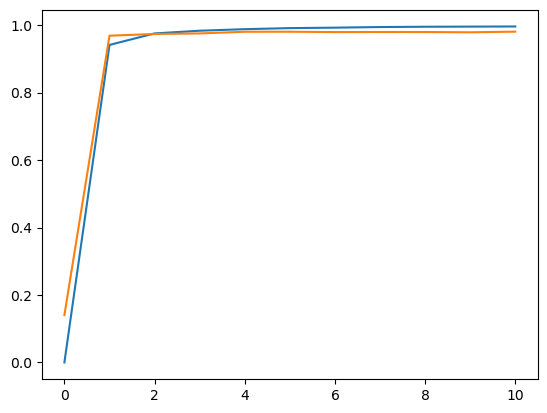

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(lightning_model.training_accuracy_history)
plt.plot(lightning_model.validation_accuracy_history)